In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Datasets_AIML/Scene Classification.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Datasets_AIML")

In [ ]:
# import zipfile

# import os

# # Check if the zip file exists
# zip_file_path = "/content/drive/MyDrive/Datasets_AIML/Scene Classification.zip"
# if not os.path.exists(zip_file_path):
#     print(f"Error: Zip file not found at {zip_file_path}")
# else:
#     # Extract the zip file
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall("/content/drive/MyDrive/Datasets_AIML")
#     print(f"Successfully extracted {zip_file_path} to /content/drive/MyDrive/Datasets_AIML")


Successfully extracted /content/drive/MyDrive/Datasets_AIML/Scene Classification.zip to /content/drive/MyDrive/Datasets_AIML


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import shutil
import glob
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# --- GPU Configuration ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(f"GPU Configuration Error: {e}")

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# --- Basic Configuration ---
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32
EPOCHS_BASELINE = 30
EPOCHS_DEEPER = 50
EPOCHS_TRANSFER = 20
NUM_CLASSES = 6
SEED = 1337

In [ ]:
BASE_DATA_DIR = '/content/drive/MyDrive/Datasets_AIML/Scene Classification'
TRAIN_DIR = '/content/drive/MyDrive/Datasets_AIML/Scene Classification/train'
VALIDATION_DIR = '/content/drive/MyDrive/Datasets_AIML/Scene Classification/validation'
TEST_DIR = '/content/drive/MyDrive/Datasets_AIML/Scene Classification/test'
CORRUPTED_IMAGES_DIR = '/content/drive/MyDrive/Datasets_AIML/Scene Classification/corrupted_images'


In [ ]:
# Ensure base directory exists
if not os.path.exists(BASE_DATA_DIR):
    print(f"ERROR: Base data directory not found at {BASE_DATA_DIR}")
    exit() # Or handle appropriately

os.makedirs(CORRUPTED_IMAGES_DIR, exist_ok=True)

CLASS_NAMES_LIST = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] # For reference

DATA PREPARATION: TRAIN/VALIDATION SPLIT

In [ ]:
corrupted_images = []  # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in CLASS_NAMES_LIST:
    class_path = os.path.join(TRAIN_DIR, class_name)

    if os.path.isdir(class_path):  # Ensure it’s a valid directory
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")


Corrupted Images Found:
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/10126.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/15487.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/6871.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/7108.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/8431.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/8748.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/906.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/forest/11977.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/forest/134.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/forest/1554.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/forest/5818.jpg
/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/forest/67

In [ ]:
# --- 1. Handle Corrupted Images ---
def handle_corrupted_images(data_directory_root, class_names, corrupted_output_dir):
    """
    Checks for corrupted images in class subdirectories and moves them.
    Args:
        data_directory_root (str): Path to the directory containing class folders (e.g., train, validation, test).
        class_names (list): List of subfolder names representing classes.
        corrupted_output_dir (str): Directory to move corrupted images to.
    """
    num_corrupted = 0
    print(f"\nChecking for corrupted images in: {data_directory_root}")
    for class_name in class_names:
        class_path = os.path.join(data_directory_root, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Class directory not found {class_path}, skipping.")
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Skip non-image files if any, based on common extensions
                if not (img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))):
                    continue
                with Image.open(img_path) as img:
                    img.verify()  # Verify if it's a valid image
                    # To be more thorough, you can try to load it:
                    # img.load() # This will raise an error for truncated files
            except (IOError, SyntaxError, UnidentifiedImageError, OSError) as e: # Added OSError for some cases
                print(f"Corrupted image found: {img_path} - Error: {e}")
                try:
                    shutil.move(img_path, os.path.join(corrupted_output_dir, os.path.basename(img_path)))
                    num_corrupted += 1
                except Exception as move_e:
                    print(f"Could not move corrupted image {img_path}: {move_e}")
            except Exception as general_e: # Catch other potential errors during open/verify
                 print(f"An unexpected error occurred with image {img_path}: {general_e}")


    if num_corrupted > 0:
        print(f"Moved {num_corrupted} corrupted images from {data_directory_root} to '{corrupted_output_dir}'.")
    else:
        print(f"No corrupted images found or moved from {data_directory_root}.")
    return num_corrupted


print("--- Checking and Moving Corrupted Images ---")
# Important: Make sure TRAIN_DIR, VALIDATION_DIR, TEST_DIR point to the *actual* directories
# containing class subfolders.
if os.path.exists(TRAIN_DIR):
    handle_corrupted_images(TRAIN_DIR, CLASS_NAMES_LIST, CORRUPTED_IMAGES_DIR)
if os.path.exists(TEST_DIR):
    handle_corrupted_images(TEST_DIR, CLASS_NAMES_LIST, CORRUPTED_IMAGES_DIR)
print("--- Finished Corrupted Image Check ---")


# import shutil

# corrupted_dir = "corrupted_images"
# os.makedirs(corrupted_dir, exist_ok=True)

# for img_path in corrupted_images:
#     shutil.move(img_path, os.path.join(corrupted_dir, os.path.basename(img_path)))
# print(f"\nMoved {len(corrupted_images)} corrupted images to '{corrupted_dir}'.")


--- Checking and Moving Corrupted Images ---

Checking for corrupted images in: /content/drive/MyDrive/Datasets_AIML/Scene Classification/train
Corrupted image found: /content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/10126.jpg - Error: cannot identify image file '/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/10126.jpg'
Corrupted image found: /content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/15487.jpg - Error: cannot identify image file '/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/15487.jpg'
Corrupted image found: /content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/6871.jpg - Error: cannot identify image file '/content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/6871.jpg'
Corrupted image found: /content/drive/MyDrive/Datasets_AIML/Scene Classification/train/buildings/7108.jpg - Error: cannot identify image file '/content/drive/MyDrive/Datas

In [ ]:
def display_corrupted_images(corrupted_dir, max_images=5):
    """
    Displays a few images from the corrupted images directory.
    Args:
        corrupted_dir (str): Path to the directory containing corrupted images.
        max_images (int): Maximum number of images to attempt to display.
    """
    corrupted_files = [f for f in os.listdir(corrupted_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    if not corrupted_files:
        print("No corrupted images to display.")
        return

    print(f"\nDisplaying up to {max_images} corrupted images from '{corrupted_dir}'...")
    num_displayed = 0

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(corrupted_files[:max_images]):
        img_path = os.path.join(corrupted_dir, img_name)
        try:
            with Image.open(img_path) as img:
                plt.subplot(1, max_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{img_name}")
                num_displayed += 1
        except (IOError, SyntaxError, UnidentifiedImageError, OSError) as e:
            print(f"Could not open {img_name}: {e}")
            continue

    plt.tight_layout()
    plt.show()
    print(f"\nDisplayed {num_displayed} corrupted images.")

# Call the display function after handling corruption
display_corrupted_images(CORRUPTED_IMAGES_DIR, max_images=5)


In [ ]:
class_counts = {}

for class_name in CLASS_NAMES_LIST:
    class_path = os.path.join(TRAIN_DIR, class_name)

    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)  # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)

for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")

print("=" * 45)

# Plotting the Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Valid Images')
plt.title('Class Distribution of Training Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Class Distribution:
Class Name               Valid Image Count
buildings                           2184
forest                              2264
glacier                             2397
mountain                            2505
sea                                 2267
street                              2375


In [ ]:
import random
selected_images = []  # Store image paths
selected_labels = []  # Store corresponding class names

for class_name in CLASS_NAMES_LIST:
    class_path = os.path.join(TRAIN_DIR, class_name)

    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if images:  # Ensure the class folder is not empty
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

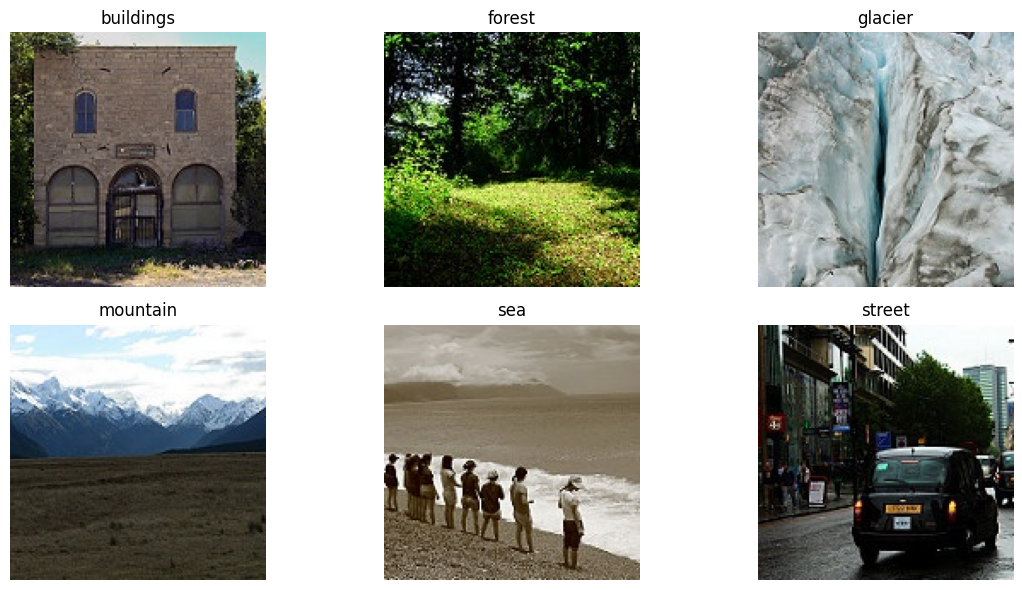

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Determine columns
rows = 2  # Fixed rows for layout

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")  # Hide empty subplots

plt.tight_layout()
plt.show()


DATA GENERATORS

In [ ]:
# --- 2. Create Datasets using image_dataset_from_directory ---
# This utility is great for creating tf.data.Dataset objects directly.
# It can also handle validation splits.

# If you have a separate VALIDATION_DIR, load it separately.
# If you want to split TRAIN_DIR into train and validation:
print("\n--- Creating Train/Validation Datasets using image_dataset_from_directory ---")
if not os.path.exists(TRAIN_DIR):
    print(f"ERROR: Training directory {TRAIN_DIR} not found. Cannot create datasets.")
    # exit() # Or handle error
else:
    train_ds = image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2, # 20% for validation
        subset="training",
        seed=SEED,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical' # for multi-class classification
    )

    val_ds = image_dataset_from_directory(
        TRAIN_DIR, # Same directory for splitting
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )


--- Creating Train/Validation Datasets using image_dataset_from_directory ---
Found 13992 files belonging to 6 classes.
Using 11194 files for training.
Found 13992 files belonging to 6 classes.
Using 2798 files for validation.


In [ ]:
# Get class names from the dataset (IMPORTANT for consistency)
CLASS_NAMES_FROM_DS = train_ds.class_names
print("Class names from dataset:", CLASS_NAMES_FROM_DS)
if len(CLASS_NAMES_FROM_DS) != NUM_CLASSES:
  print(f"WARNING: Discovered {len(CLASS_NAMES_FROM_DS)} classes, but NUM_CLASSES is {NUM_CLASSES}. Check dataset.")
        # NUM_CLASSES = len(CLASS_NAMES_FROM_DS) # Optionally update NUM_CLASSES

Class names from dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
 # --- Data Augmentation and Preprocessing for tf.data.Dataset ---
data_augmentation_layers = Sequential([
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED), # Factor of 2pi
        layers.RandomZoom(0.1, seed=SEED),
        layers.RandomContrast(0.1, seed=SEED)
        # Add more as needed: RandomHeight, RandomWidth, etc.
    ])

In [ ]:
# Normalization layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
for images, labels in train_ds.take(1):
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 150, 150, 3)
Labels shape: (32, 6)


In [ ]:
def preprocess_dataset(image, label):
        image = normalization_layer(image) # Normalize first
        return image, label


def augment_dataset(image, label):
        image = data_augmentation_layers(image, training=True) # Apply augmentation
        return image, label

# #sample augmentation
# from tensorflow.keras import layers

# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images)
#     return images


In [ ]:
if 'train_ds' in locals(): # Check if train_ds was created
        train_ds = train_ds.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(augment_dataset, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
if 'val_ds' in locals(): # Check if val_ds was created
        val_ds = val_ds.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print("\n--- Creating Test Dataset using ImageDataGenerator ---")
if not os.path.exists(TEST_DIR):
    print(f"WARNING: Test directory {TEST_DIR} not found. Test evaluation will be skipped.")
    test_generator = None
else:
    test_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for test
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False, # Important for evaluation
        # Ensure class_names align if you use custom CLASS_NAMES in evaluation
        classes=CLASS_NAMES_FROM_DS if 'CLASS_NAMES_FROM_DS' in locals() else None
    )
    if test_generator and CLASS_NAMES_FROM_DS:
         print("Test Generator Class Indices:", test_generator.class_indices)


--- Creating Test Dataset using ImageDataGenerator ---
Found 3000 images belonging to 6 classes.
Test Generator Class Indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


FUnctions for Plotting and Evaluation

In [ ]:
def plot_training_history(history, title_suffix=""):
    # (This function remains largely the same)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.show()

In [ ]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # (This function remains largely the same)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right") # Adjusted rotation for better label visibility
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
def evaluate_model_custom(model, test_data, model_name="Model", class_names_for_report=None):
    print(f"\n--- Evaluating {model_name} ---")
    if test_data is None:
        print(f"Test data for {model_name} is not available. Skipping evaluation.")
        return 0.0, 0.0 # Return dummy values

    loss, accuracy = model.evaluate(test_data, verbose=1)
    print(f"{model_name} Test Accuracy: {accuracy*100:.2f}%")
    print(f"{model_name} Test Loss: {loss:.4f}")

    Y_pred_probs = model.predict(test_data)
    Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

    # Get true labels
    if isinstance(test_data, tf.data.Dataset):
        Y_true = np.concatenate([y for x, y in test_data], axis=0)
        Y_true = np.argmax(Y_true, axis=1) # Convert from one-hot if needed
    elif hasattr(test_data, 'classes'): # For ImageDataGenerator
        Y_true = test_data.classes
    else:
        print("Could not determine true labels from test_data type.")
        return accuracy, loss

In [ ]:
def evaluate_model_custom(model, test_data, model_name="Model", class_names_for_report=None):
    print(f"\n--- Evaluating {model_name} ---")
    if test_data is None:
        print(f"Test data for {model_name} is not available. Skipping evaluation.")
        return 0.0, 0.0 # Return dummy values

    loss, accuracy = model.evaluate(test_data, verbose=1)
    print(f"{model_name} Test Accuracy: {accuracy*100:.2f}%")
    print(f"{model_name} Test Loss: {loss:.4f}")

    Y_pred_probs = model.predict(test_data)
    Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

    # Get true labels
    if isinstance(test_data, tf.data.Dataset):
        Y_true = np.concatenate([y for x, y in test_data], axis=0)
        Y_true = np.argmax(Y_true, axis=1) # Convert from one-hot if needed
    elif hasattr(test_data, 'classes'): # For ImageDataGenerator
        Y_true = test_data.classes
    else:
        print("Could not determine true labels from test_data type.")
        return accuracy, loss

    print("\nClassification Report:")
    if class_names_for_report:
        print(classification_report(Y_true, Y_pred_classes, target_names=class_names_for_report, zero_division=0))
    else:
        print("Warning: class_names_for_report not provided for classification_report.")
        print(classification_report(Y_true, Y_pred_classes, zero_division=0))


    cm = confusion_matrix(Y_true, Y_pred_classes)
    if class_names_for_report:
        plot_confusion_matrix_custom(cm, classes=class_names_for_report, title=f'Confusion Matrix - {model_name}')
    else:
        print("Warning: class_names_for_report not provided for confusion matrix plot.")
    return accuracy, loss

Model Defination

In [ ]:
def create_baseline_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
def create_deeper_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling2D((2, 2)), layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling2D((2, 2)), layers.Dropout(0.25),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling2D((2, 2)), layers.Dropout(0.25),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling2D((2, 2)), layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(512), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
        layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
baseline_accuracy, baseline_loss = 0.0, 0.0
deeper_adam_accuracy, deeper_adam_loss = 0.0, 0.0
deeper_sgd_accuracy, deeper_sgd_loss = 0.0, 0.0
transfer_accuracy, transfer_loss = 0.0, 0.0

In [ ]:
current_class_names = CLASS_NAMES_FROM_DS if 'CLASS_NAMES_FROM_DS' in locals() else CLASS_NAMES_LIST


--- Baseline Model Training & Evaluation ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,410,438 (20.64 MB)

 Trainable params: 5,410,438 (20.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 103s 56ms/step - accuracy: 0.4860 - loss: 1.2812 - val_accuracy: 0.6705 - val_loss: 0.9026
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.7022 - loss: 0.8052 - val_accuracy: 0.7230 - val_loss: 0.7458
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7709 - loss: 0.6221 - val_accuracy: 0.7702 - val_loss: 0.6450
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8377 - loss: 0.4552 - val_accuracy: 0.7473 - val_loss: 0.7207
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8992 - loss: 0.2911 - val_accuracy: 0.7287 - val_loss: 0.9846
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9425 - loss: 0.1677 - val_accuracy: 0.7409 - val_loss: 1.1039
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9583 - loss: 0.1165 - val_accuracy: 0.7563 - val_loss: 1.2608
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9696 - loss: 0.0879 - val

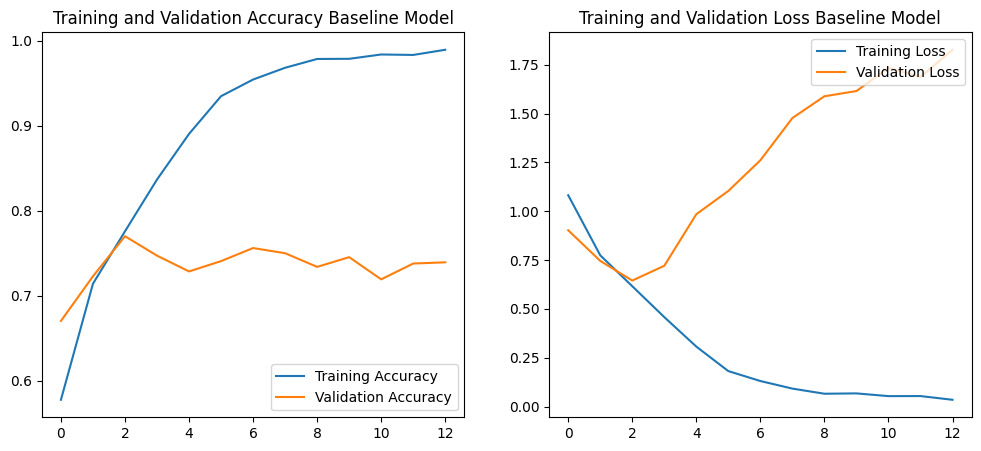


--- Evaluating Baseline Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8039 - loss: 0.5555
Baseline Model Test Accuracy: 77.43%
Baseline Model Test Loss: 0.6579
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.65      0.78      0.71       437
      forest       0.90      0.94      0.92       474
     glacier       0.75      0.76      0.75       553
    mountain       0.75      0.75      0.75       525
         sea       0.82      0.65      0.73       510
      street       0.80      0.78      0.79       501

    accuracy                           0.77      3000
   macro avg       0.78      0.78      0.77      3000
weighted avg       0.78      0.77      0.77      3000

Confusion matrix, without normalization


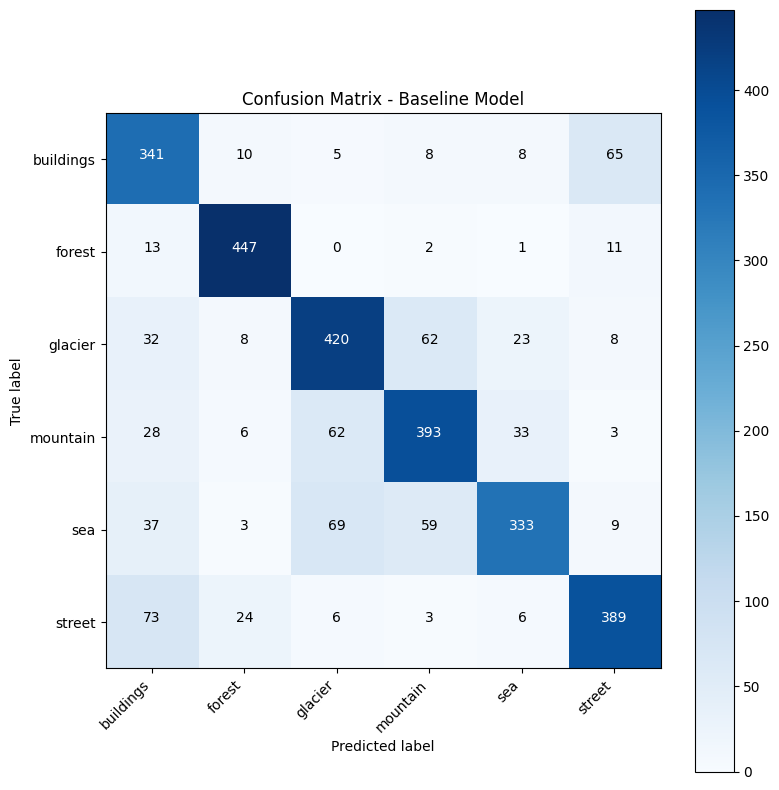

In [ ]:
print("\n--- Baseline Model Training & Evaluation ---")
baseline_model = create_baseline_model(num_classes=len(current_class_names))
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()
early_stopping_baseline = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_baseline = ModelCheckpoint('baseline_model_best.keras', save_best_only=True, monitor='val_loss')
history_baseline = baseline_model.fit(train_ds, epochs=EPOCHS_BASELINE, validation_data=val_ds, callbacks=[early_stopping_baseline, checkpoint_baseline])
plot_training_history(history_baseline, "Baseline Model")
baseline_model.load_weights('baseline_model_best.keras')
baseline_accuracy, baseline_loss = evaluate_model_custom(baseline_model, test_generator, "Baseline Model", current_class_names)





--- Deeper Model (Adam) Training & Evaluation ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 11,143,622 (42.51 MB)

 Trainable params: 11,141,126 (42.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.4994 - loss: 1.3936 - val_accuracy: 0.4460 - val_loss: 1.4852
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6746 - loss: 0.8993 - val_accuracy: 0.6916 - val_loss: 0.8266
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.7174 - loss: 0.7676 - val_accuracy: 0.7670 - val_loss: 0.6363
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7447 - loss: 0.6967 - val_accuracy: 0.5086 - val_loss: 1.7487
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7638 - loss: 0.6345 - val_accuracy: 0.7963 - val_loss: 0.5386
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7964 - loss: 0.5603 - val_accuracy: 0.6122 - val_loss: 1.4158
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.8158 - loss: 0.5218 - val_accuracy: 0.5808 - val_loss: 1.3476
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8339 - loss: 0.4606 - 

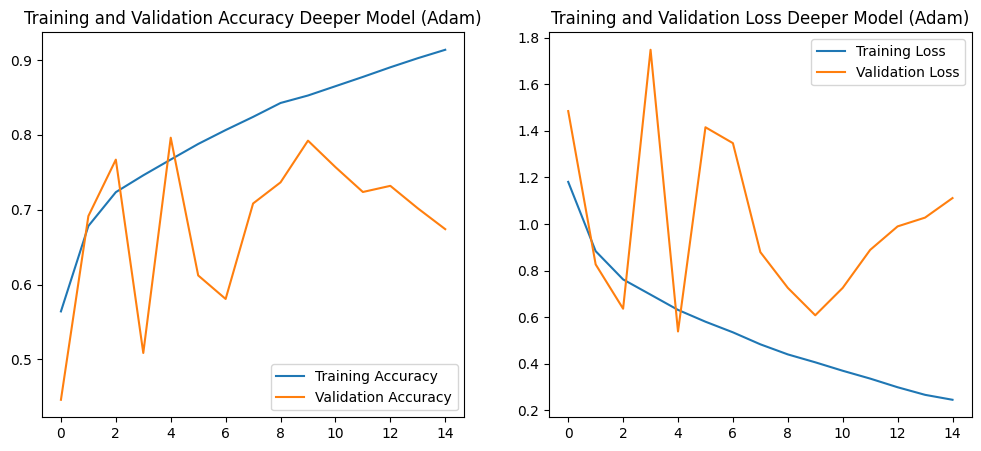


--- Evaluating Deeper Model (Adam) ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8038 - loss: 0.5202
Deeper Model (Adam) Test Accuracy: 79.53%
Deeper Model (Adam) Test Loss: 0.5605
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.74      0.81      0.77       437
      forest       0.93      0.91      0.92       474
     glacier       0.83      0.64      0.72       553
    mountain       0.66      0.84      0.74       525
         sea       0.85      0.74      0.79       510
      street       0.82      0.85      0.84       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000

Confusion matrix, without normalization


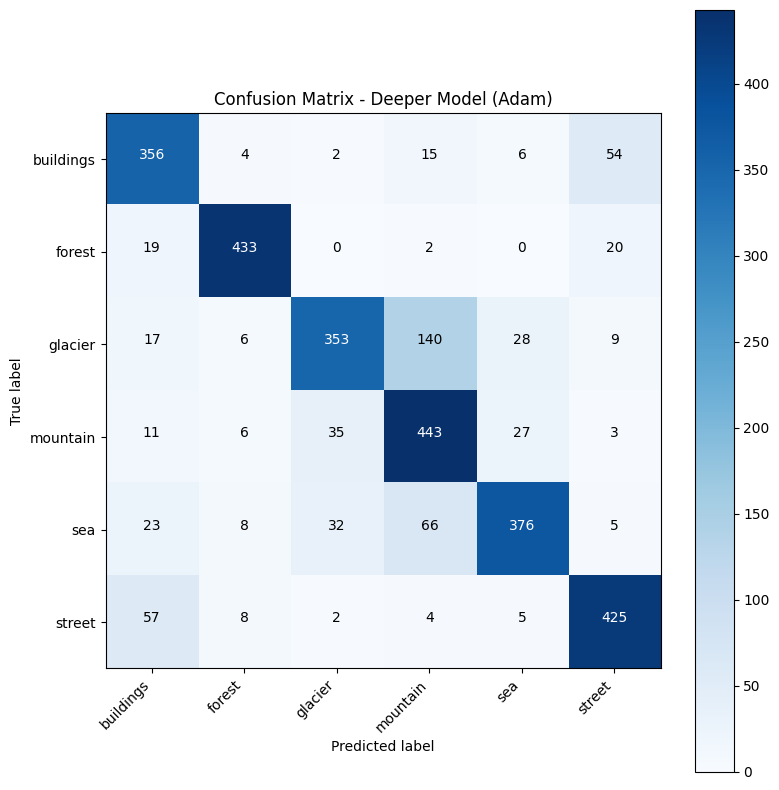

In [ ]:
print("\n--- Deeper Model (Adam) Training & Evaluation ---")
deeper_model_adam = create_deeper_model(num_classes=len(current_class_names))
deeper_model_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
deeper_model_adam.summary()
early_stopping_deeper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_deeper_adam = ModelCheckpoint('deeper_model_adam_best.keras', save_best_only=True, monitor='val_loss')
history_deeper_adam = deeper_model_adam.fit(train_ds, epochs=EPOCHS_DEEPER, validation_data=val_ds, callbacks=[early_stopping_deeper, checkpoint_deeper_adam])
plot_training_history(history_deeper_adam, "Deeper Model (Adam)")
deeper_model_adam.load_weights('deeper_model_adam_best.keras')
deeper_adam_accuracy, deeper_adam_loss = evaluate_model_custom(deeper_model_adam, test_generator, "Deeper Model (Adam)", current_class_names)



--- Deeper Model (SGD) Training & Evaluation ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.4736 - loss: 1.4349 - val_accuracy: 0.4464 - val_loss: 1.4164
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6242 - loss: 0.9930 - val_accuracy: 0.5347 - val_loss: 1.3518
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6567 - loss: 0.9146 - val_accuracy: 0.7230 - val_loss: 0.7753
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6926 - loss: 0.8231 - val_accuracy: 0.6716 - val_loss: 0.9029
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7200 - loss: 0.7604 - val_accuracy: 0.6090 - val_loss: 1.2990
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7415 - loss: 0.7067 - val_accuracy: 0.4803 - val_loss: 1.6390
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7615 - loss: 0.6503 - val_accuracy: 0.7262 - val_loss: 0.7140
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7772 - loss: 0.6207 - val_accurac

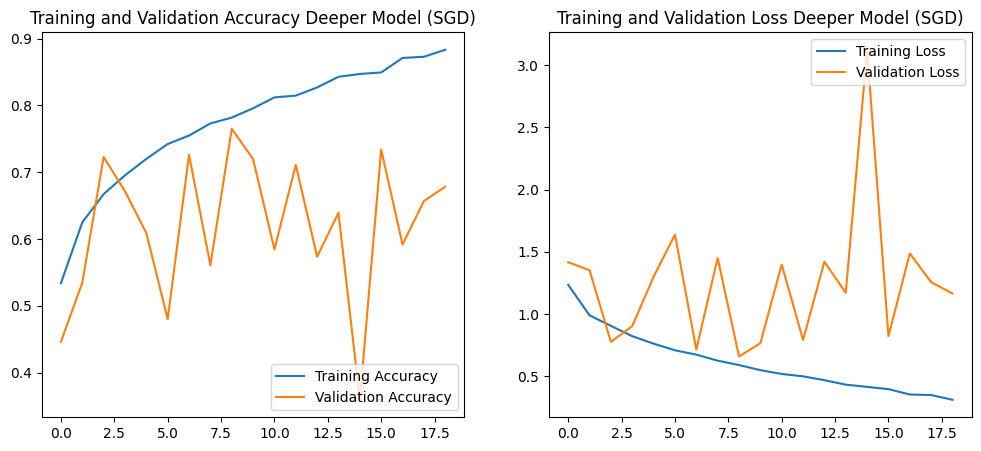


--- Evaluating Deeper Model (SGD) ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7886 - loss: 0.6639
Deeper Model (SGD) Test Accuracy: 78.57%
Deeper Model (SGD) Test Loss: 0.6259
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.80      0.69      0.74       437
      forest       0.89      0.97      0.93       474
     glacier       0.65      0.85      0.74       553
    mountain       0.77      0.68      0.72       525
         sea       0.77      0.80      0.79       510
      street       0.92      0.71      0.80       501

    accuracy                           0.79      3000
   macro avg       0.80      0.78      0.79      3000
weighted avg       0.80      0.79      0.79      3000

Confusion matrix, without normalization


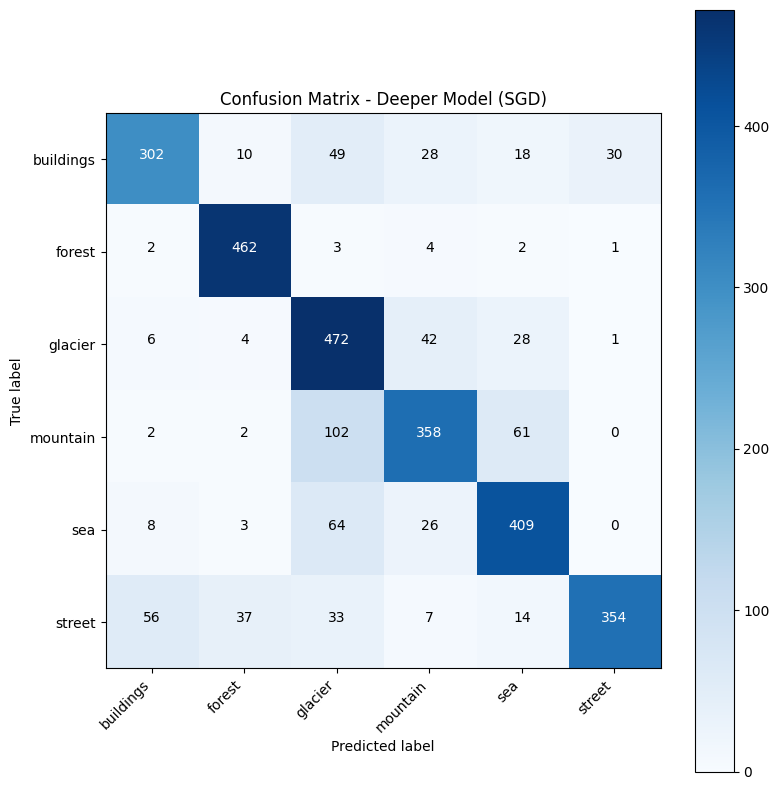

In [ ]:
print("\n--- Deeper Model (SGD) Training & Evaluation ---")
deeper_model_sgd = create_deeper_model(num_classes=len(current_class_names))
deeper_model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# No summary if architecture is identical
checkpoint_deeper_sgd = ModelCheckpoint('deeper_model_sgd_best.keras', save_best_only=True, monitor='val_loss')
history_deeper_sgd = deeper_model_sgd.fit(train_ds, epochs=EPOCHS_DEEPER, validation_data=val_ds, callbacks=[early_stopping_deeper, checkpoint_deeper_sgd])
plot_training_history(history_deeper_sgd, "Deeper Model (SGD)")
deeper_model_sgd.load_weights('deeper_model_sgd_best.keras')
deeper_sgd_accuracy, deeper_sgd_loss = evaluate_model_custom(deeper_model_sgd, test_generator, "Deeper Model (SGD)", current_class_names)

Transfer Learning

In [ ]:
IMG_WIDTH_TL = 224
IMG_HEIGHT_TL = 224

In [ ]:
print(f"\n--- Creating Data Generators for Transfer Learning (Input: {IMG_HEIGHT_TL}x{IMG_WIDTH_TL}) ---")


--- Creating Data Generators for Transfer Learning (Input: 224x224) ---


In [ ]:
train_datagen_tl = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

In [ ]:
# For validation and testing: only MobileNetV2 preprocessing
validation_datagen_tl = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator_tl = train_datagen_tl.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Use 80% for training
    shuffle=True
)



Found 11196 images belonging to 6 classes.


In [ ]:
validation_generator_tl = train_datagen_tl.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Use 20% for validation
    shuffle=False
)

test_generator_tl = validation_datagen_tl.flow_from_directory( # Use validation_datagen_tl for test
    TEST_DIR,
    target_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Verify class indices for TL generator if needed, should be same
print("Class Indices from TL Training Generator:", train_generator_tl.class_indices)

Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Class Indices from TL Training Generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
def create_transfer_learning_model(input_shape=(IMG_HEIGHT_TL, IMG_WIDTH_TL, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Remove ImageNet classifier
                                                   weights='imagenet')
    # Freeze the base model initially
    base_model.trainable = False

    # Add custom classifier on top
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(), # Efficient alternative to Flatten
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model, base_model

In [ ]:
print("\n--- Transfer Learning Model (MobileNetV2) ---")
transfer_model, base_transfer_model = create_transfer_learning_model()
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
transfer_model.summary()


--- Transfer Learning Model (MobileNetV2) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 1. Feature Extraction (train only the top layers)
print("\nTraining Transfer Learning Model (Feature Extraction)...")
early_stopping_tl_feature = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) # Shorter patience
checkpoint_tl_feature = ModelCheckpoint('transfer_model_feature_extraction_best.keras', save_best_only=True, monitor='val_loss')


Training Transfer Learning Model (Feature Extraction)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 250s 638ms/step - accuracy: 0.7464 - loss: 0.6883 - val_accuracy: 0.8691 - val_loss: 0.3634
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 210s 600ms/step - accuracy: 0.8589 - loss: 0.3791 - val_accuracy: 0.8684 - val_loss: 0.3394
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 213s 610ms/step - accuracy: 0.8714 - loss: 0.3607 - val_accuracy: 0.8863 - val_loss: 0.3007
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 209s 598ms/step - accuracy: 0.8733 - loss: 0.3409 - val_accuracy: 0.8816 - val_loss: 0.3035
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 212s 605ms/step - accuracy: 0.8809 - loss: 0.3320 - val_accuracy: 0.8881 - val_loss: 0.2840
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 211s 605ms/step - accuracy: 0.8831 - loss: 0.3227 - val_accuracy: 0.8898 - val_loss: 0.2912
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 210s 600ms/step - accuracy: 0.8857 - loss: 0.2958 - val_accuracy: 0.8934 - val_loss: 0.2867
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 210s 600ms/step - accuracy: 0.8843 -

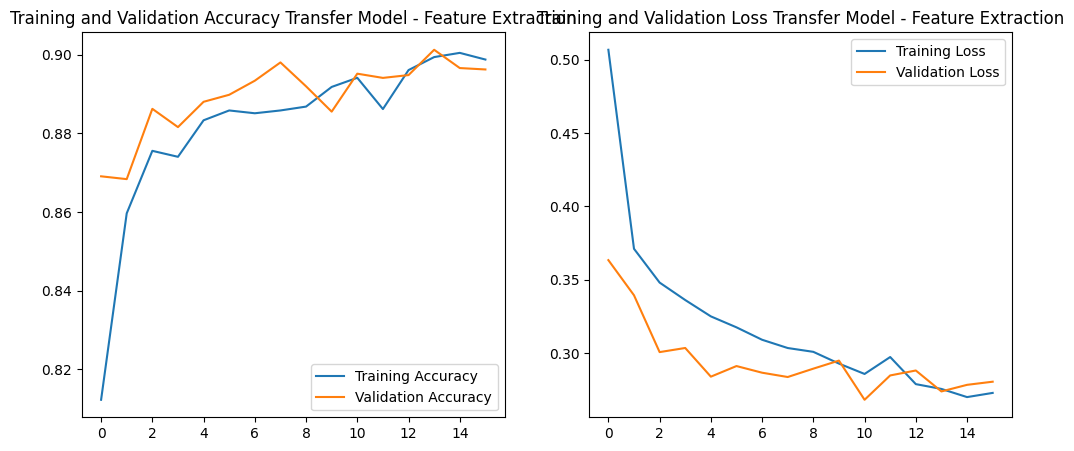

In [ ]:
history_tl_feature_extraction = transfer_model.fit(
    train_generator_tl,
    epochs=EPOCHS_TRANSFER, # Fewer epochs for feature extraction
    validation_data=validation_generator_tl,
    callbacks=[early_stopping_tl_feature, checkpoint_tl_feature]
)
plot_training_history(history_tl_feature_extraction, "Transfer Model - Feature Extraction")

In [ ]:
print("Loading best weights for transfer model after feature extraction...")
transfer_model.load_weights('transfer_model_feature_extraction_best.keras')

Loading best weights for transfer model after feature extraction...


In [ ]:
# 2. Fine-Tuning (unfreeze some layers of the base model)
print("\nFine-tuning Transfer Learning Model...")
base_transfer_model.trainable = True # Unfreeze the base model

# Fine-tune from a certain layer onwards. For MobileNetV2, let's say last 30 layers.
# Check base_transfer_model.layers to see layer names and choose appropriately.
fine_tune_at = len(base_transfer_model.layers) - 30 # Example: unfreeze last 30 layers
for layer in base_transfer_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_transfer_model.layers[fine_tune_at:]:
    print(f"Layer {layer.name} is trainable: {layer.trainable}")


Fine-tuning Transfer Learning Model...
Layer block_13_project_BN is trainable: True
Layer block_14_expand is trainable: True
Layer block_14_expand_BN is trainable: True
Layer block_14_expand_relu is trainable: True
Layer block_14_depthwise is trainable: True
Layer block_14_depthwise_BN is trainable: True
Layer block_14_depthwise_relu is trainable: True
Layer block_14_project is trainable: True
Layer block_14_project_BN is trainable: True
Layer block_14_add is trainable: True
Layer block_15_expand is trainable: True
Layer block_15_expand_BN is trainable: True
Layer block_15_expand_relu is trainable: True
Layer block_15_depthwise is trainable: True
Layer block_15_depthwise_BN is trainable: True
Layer block_15_depthwise_relu is trainable: True
Layer block_15_project is trainable: True
Layer block_15_project_BN is trainable: True
Layer block_15_add is trainable: True
Layer block_16_expand is trainable: True
Layer block_16_expand_BN is trainable: True
Layer block_16_expand_relu is trainabl

In [ ]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Much lower LR
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
transfer_model.summary() # See trainable params change

early_stopping_tl_finetune = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
checkpoint_tl_finetune = ModelCheckpoint('transfer_model_finetuned_best.keras', save_best_only=True, monitor='val_loss')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 1,855,878 (7.08 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 17/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 239s 636ms/step - accuracy: 0.7857 - loss: 0.6090 - val_accuracy: 0.9027 - val_loss: 0.2876
Epoch 18/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 213s 609ms/step - accuracy: 0.8693 - loss: 0.3688 - val_accuracy: 0.9020 - val_loss: 0.2762
Epoch 19/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 223s 639ms/step - accuracy: 0.8740 - loss: 0.3350 - val_accuracy: 0.9052 - val_loss: 0.2672
Epoch 20/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 218s 622ms/step - accuracy: 0.8927 - loss: 0.3065 - val_accuracy: 0.9081 - val_loss: 0.2465
Epoch 21/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 218s 622ms/step - accuracy: 0.9001 - loss: 0.2843 - val_accuracy: 0.9059 - val_loss: 0.2719
Epoch 22/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 216s 617ms/step - accuracy: 0.9005 - loss: 0.2715 - val_accuracy: 0.9081 - val_loss: 0.2631
Epoch 23/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 219s 627ms/step - accuracy: 0.9015 - loss: 0.2666 - val_accuracy: 0.9095 - val_loss: 0.2498
Epoch 24/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 221s 631ms/step - accuracy: 

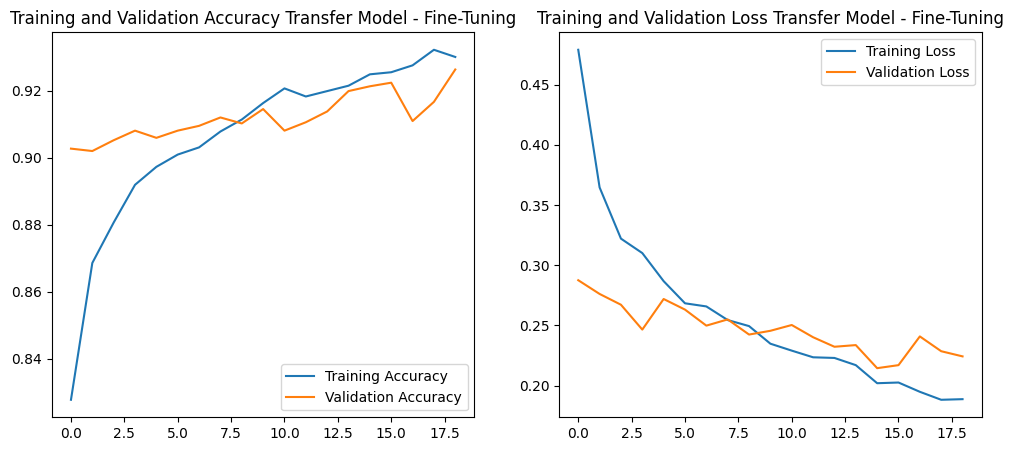

In [ ]:
# Continue training (fine-tuning)
history_tl_fine_tuning = transfer_model.fit(
    train_generator_tl,
    epochs=EPOCHS_TRANSFER + 15, # More epochs for fine-tuning, can be EPOCHS_DEEPER
    initial_epoch=history_tl_feature_extraction.epoch[-1] +1, # Continue from where feature extraction left off
    validation_data=validation_generator_tl,
    callbacks=[early_stopping_tl_finetune, checkpoint_tl_finetune]
)
plot_training_history(history_tl_fine_tuning, "Transfer Model - Fine-Tuning")

In [ ]:
print("Loading best weights for transfer model after fine-tuning...")
transfer_model.load_weights('transfer_model_finetuned_best.keras')
transfer_accuracy, transfer_loss = evaluate_model_custom(transfer_model, test_generator_tl, "Transfer Learning Model (Fine-Tuned)")

Loading best weights for transfer model after fine-tuning...

--- Evaluating Transfer Learning Model (Fine-Tuned) ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9212 - loss: 0.2016
Transfer Learning Model (Fine-Tuned) Test Accuracy: 92.43%
Transfer Learning Model (Fine-Tuned) Test Loss: 0.2002
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       437
           1       0.99      0.99      0.99       474
           2       0.87      0.87      0.87       553
           3       0.89      0.85      0.87       525
           4       0.94      0.97      0.95       510
           5       0.93      0.96      0.94       501

    accuracy                           0.92      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.92      0.92      0.92      3000



In [ ]:
# # Create new tf.data.Dataset for transfer learning with appropriate size and preprocessing
# if not os.path.exists(TRAIN_DIR):
#     print(f"ERROR: Training directory {TRAIN_DIR} not found. Skipping Transfer Learning.")
#     train_ds_tl, val_ds_tl, test_ds_tl = None, None, None
# else:
#     train_ds_tl = image_dataset_from_directory(
#         TRAIN_DIR, validation_split=0.2, subset="training", seed=SEED,
#         image_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL), batch_size=BATCH_SIZE, label_mode='categorical'
#     )
#     val_ds_tl = image_dataset_from_directory(
#         TRAIN_DIR, validation_split=0.2, subset="validation", seed=SEED,
#         image_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL), batch_size=BATCH_SIZE, label_mode='categorical'
#     )
#     # Test set for transfer learning
#     if os.path.exists(TEST_DIR):
#         test_ds_tl = image_dataset_from_directory(
#             TEST_DIR, image_size=(IMG_HEIGHT_TL, IMG_WIDTH_TL), batch_size=BATCH_SIZE,
#             label_mode='categorical', shuffle=False # No validation_split or subset for test
#         )
#     else:
#         test_ds_tl = None
#         print(f"WARNING: Test directory {TEST_DIR} not found. Transfer learning test evaluation will be skipped.")


#     # Preprocessing specific to MobileNetV2 for tf.data.Dataset
#     def preprocess_for_mobilenetv2(image, label):
#         image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
#         return image, label

#     if train_ds_tl:
#         train_ds_tl = train_ds_tl.map(preprocess_for_mobilenetv2, num_parallel_calls=tf.data.AUTOTUNE)
#         # Augmentation can be added here as well if desired, after mobilenet preprocessing
#         # train_ds_tl = train_ds_tl.map(augment_dataset, num_parallel_calls=tf.data.AUTOTUNE) # Reusing augment_dataset
#         train_ds_tl = train_ds_tl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#     if val_ds_tl:
#         val_ds_tl = val_ds_tl.map(preprocess_for_mobilenetv2, num_parallel_calls=tf.data.AUTOTUNE)
#         val_ds_tl = val_ds_tl.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#     if test_ds_tl:
#         test_ds_tl = test_ds_tl.map(preprocess_for_mobilenetv2, num_parallel_calls=tf.data.AUTOTUNE)
#         test_ds_tl = test_ds_tl.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


#     # Transfer Learning Model Definition
#     def create_transfer_learning_model_tl(input_shape=(IMG_HEIGHT_TL, IMG_WIDTH_TL, 3), num_classes_tl=NUM_CLASSES):
#         base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
#         base_model.trainable = False # Freeze base
#         model = Sequential([
#             base_model,
#             layers.GlobalAveragePooling2D(),
#             layers.Dense(256, activation='relu'), layers.Dropout(0.5),
#             layers.Dense(num_classes_tl, activation='softmax')
#         ])
#         return model, base_model

#     if train_ds_tl and val_ds_tl:
#         print("\n--- Transfer Learning Model (MobileNetV2) Training ---")
#         transfer_model, base_transfer_model = create_transfer_learning_model_tl(num_classes_tl=len(current_class_names))
#         transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#         transfer_model.summary()

#         print("\nFeature Extraction Phase...")
#         early_stop_tl_feat = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#         chkpt_tl_feat = ModelCheckpoint('transfer_model_feature_extraction_best.keras', save_best_only=True, monitor='val_loss')
#         history_tl_feat = transfer_model.fit(train_ds_tl, epochs=EPOCHS_TRANSFER, validation_data=val_ds_tl, callbacks=[early_stop_tl_feat, chkpt_tl_feat])
#         plot_training_history(history_tl_feat, "Transfer Model - Feature Extraction")
#         transfer_model.load_weights('transfer_model_feature_extraction_best.keras')

#         print("\nFine-Tuning Phase...")
#         base_transfer_model.trainable = True
#         fine_tune_at = len(base_transfer_model.layers) - 30
#         for layer in base_transfer_model.layers[:fine_tune_at]:
#             layer.trainable = False

#         transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#         transfer_model.summary() # See changed trainable params
#         early_stop_tl_fine = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
#         chkpt_tl_fine = ModelCheckpoint('transfer_model_finetuned_best.keras', save_best_only=True, monitor='val_loss')
#         history_tl_fine = transfer_model.fit(
#             train_ds_tl, epochs=EPOCHS_TRANSFER + 15, initial_epoch=history_tl_feat.epoch[-1] + 1,
#             validation_data=val_ds_tl, callbacks=[early_stop_tl_fine, chkpt_tl_fine]
#         )
#         plot_training_history(history_tl_fine, "Transfer Model - Fine-Tuning")
#         transfer_model.load_weights('transfer_model_finetuned_best.keras')
#         transfer_accuracy, transfer_loss = evaluate_model_custom(transfer_model, test_ds_tl, "Transfer Learning (Fine-Tuned)", current_class_names)
#     else:
#         print("Skipping Transfer Learning model training as train_ds_tl or val_ds_tl is not available.")

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np

# # Define a simple CNN model
# model = keras.Sequential([
#     layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation="relu"),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation="relu"),
#     layers.Dense(10, activation="softmax")  # 10 classes for MNIST digits
# ])

# # Compile the model
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Train the model
# model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# # Evaluate the model
# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f"Test accuracy: {test_acc:.4f}")

# # Make predictions
# predictions = model.predict(x_test[:5])
# predicted_labels = np.argmax(predictions, axis=1)
# print("Predicted labels:", predicted_labels)
# print("Actual labels: ", y_test[:5])

In [ ]:
# --- Final Summary ---
print("\n\n--- FINAL MODEL PERFORMANCE SUMMARY ---")
print(f"Baseline Model (Scratch):         Test Accuracy = {baseline_accuracy*100:.2f}%, Test Loss = {baseline_loss:.4f}")
print(f"Deeper Model (Adam Optimizer):    Test Accuracy = {deeper_adam_accuracy*100:.2f}%, Test Loss = {deeper_adam_loss:.4f}")
print(f"Deeper Model (SGD Optimizer):     Test Accuracy = {deeper_sgd_accuracy*100:.2f}%, Test Loss = {deeper_sgd_loss:.4f}")
print(f"Transfer Learning (MobileNetV2): Test Accuracy = {transfer_accuracy*100:.2f}%, Test Loss = {transfer_loss:.4f}")



--- FINAL MODEL PERFORMANCE SUMMARY ---
Baseline Model (Scratch):         Test Accuracy = 77.43%, Test Loss = 0.6579
Deeper Model (Adam Optimizer):    Test Accuracy = 79.53%, Test Loss = 0.5605
Deeper Model (SGD Optimizer):     Test Accuracy = 78.57%, Test Loss = 0.6259
Transfer Learning (MobileNetV2): Test Accuracy = 92.43%, Test Loss = 0.2002
